In [1]:
from __future__ import print_function
from keras import regularizers
import keras
import pandas as pd
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import random
import time
import math

Using TensorFlow backend.


# Header Check Function

- The following function can be used to load header or to check what's in the csv file

In [2]:
def load_header(csv_file, print_out = False):
    
    # Loading headers
    
    headers = pd.read_csv(csv_file,header=None, nrows=1).values[0]
    idx_to_key = {}
    key_to_idx = {}
    
    for i in range(0, len(headers)):
        idx = i
        key = headers[i]
        key_to_idx[key] = idx
        idx_to_key[idx] = key
    
    if print_out is True:
        print(idx_to_key)
        
    return headers, idx_to_key, key_to_idx

# Data Loading Function

- The following function loads csv file, remove unnecessary header, shuffle, and prepare data to be suitable for training
- It also returns column names for later usage

In [3]:
def data_load(csv_file, cols_to_remove, target_col, random_state=1):
    
    # Reading data in pandas dataframe and shuffle
    
    data = pd.read_csv(csv_file).values
    data_df = pd.DataFrame(data)
    data_df_shuffle = data_df.sample(frac=1, random_state=random_state)
    
    # splitting into input/output columns
    
    # last column is the target (LMP)
    y_train = pd.DataFrame(data_df_shuffle[target_col])

    # training set is without last column
    data_df_shuffle.drop(data_df.columns[cols_to_remove+[target_col]],axis=1, inplace=True)
    x_train = data_df_shuffle.copy()

    # Loading headers
    
    headers, idx_to_key, key_to_idx = load_header(csv_file)
        
    cols_to_remove_ = []
    headers = list(headers)
    header_y = np.array([headers[target_col]])
    for i in cols_to_remove:
        headers.remove(idx_to_key[i])
    
    headers.remove(idx_to_key[target_col])
        
    # dataframe to numpy array
    y_train = y_train.values
    x_train = x_train.values

    # reshaping target values
    y_train = y_train.reshape(y_train.shape[0],1)

    # set data types
    x_train = x_train.astype('float32')
    y_train = y_train.astype('float32')
    header_x = np.array(headers)
    
    return data_df, x_train,y_train, header_x, header_y


In [4]:
def split_data(x_train, y_train, num_of_folds=5):
    
    num = x_train.shape[0]/int(num_of_folds)
    x_train_parts = []
    y_train_parts = []
    for i in range(0,int(num_of_folds)):
        start_idx = int(i*num+1) -1
        end_idx = int(num*(i+1))
        if i==int(num_of_folds)-1:
            x_train_parts.append(x_train[start_idx:])
            y_train_parts.append(y_train[start_idx:])
        else:
            x_train_parts.append(x_train[start_idx:end_idx])
            y_train_parts.append(y_train[start_idx:end_idx])

    x_trains = []
    y_trains = []
    x_tests = []
    y_tests = []
    
    for i in range(0, num_of_folds):
        x_test = x_train_parts[i]
        y_test = y_train_parts[i]
        x_train = []
        y_train = []
        for j in range(0, num_of_folds):
            if j!=i:
                x_train+=list(x_train_parts[j])
                y_train+=list(y_train_parts[j])
        
        x_trains.append(np.array(x_train))
        y_trains.append(np.array(y_train))
        x_tests.append(np.array(x_test))
        y_tests.append(np.array(y_test))
        
    return x_trains, y_trains, x_tests, y_tests

In [5]:
def corr_analysis(data_df, idx_to_key, cols_to_remove, target_col):
    corrcoefs = {}
    corrcoefs_ = {}
    for i in range(0,len(data_df.columns)):
        if i not in cols_to_remove and i != target_col:
            corrcoef = np.corrcoef(list(data_df[i].values),list(data_df[target_col].values))[0,1]
            corrcoefs[idx_to_key[i]] = corrcoef

    plt.bar(corrcoefs.keys(), corrcoefs.values(), width=0.8,color='g')
    plt.show()

    plt.bar(corrcoefs.keys(), [np.abs(i) for i in corrcoefs.values()], width=0.8,color='g')
    plt.show()


# Functions for model definition and evaluation

In [6]:
def model_define(params = [8, 8, 8], layer_n = 3, input_size = 16, dropout=0, l_2=0.01):
    
    if len(params)!=layer_n or layer_n<1:
        return None
    
    model = Sequential()
    model.add(Dense(params[0], kernel_initializer='normal', activation='relu', input_dim=input_size, kernel_regularizer=regularizers.l2(l_2)))
    
    for i in range(1, layer_n):
        if dropout!=0:
            model.add(Dropout(dropout))
        model.add(Dense(params[i], kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.l2(l_2)))
    
    model.add(Dense(1, activation = 'linear'))
    
    return model

def model_define_classifier(params = [8, 8, 8], layer_n = 3, input_size = 16, dropout=0, l_2=0.01):
    
    if len(params)!=layer_n or layer_n<1:
        return None
    
    model = Sequential()
    model.add(Dense(params[0], kernel_initializer='normal', activation='relu', input_dim=input_size, kernel_regularizer=regularizers.l2(l_2)))
    
    for i in range(1, layer_n):
        if dropout!=0:
            model.add(Dropout(dropout))
        model.add(Dense(params[i], kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.l2(l_2)))
    
    model.add(Dense(1, activation='sigmoid'))
    

    
    return model


def evaluate_model_classifier(model, x_train, y_train, x_test, y_test, epochs=1000, batch_size=8, verbose = 0, optimizer = None):
    if optimizer is None:
        optimizer = 'adam'
    
    model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
    
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=verbose,
                        validation_data=(x_test, y_test))

    score = model.evaluate(x_test, y_test, verbose=0)
    
    return score, history

def evaluate_model(model, x_train, y_train, x_test, y_test, epochs=1000, batch_size=8, verbose = 0, optimizer = None):
    if optimizer is None:
        optimizer = 'adam'
    
    model.compile(loss='mse',
                  optimizer=optimizer, metrics=['mape'])
    
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=verbose,
                        validation_data=(x_test, y_test))

    score = model.evaluate(x_test, y_test, verbose=0)
    
    return score, history

def evaluate_model_classifier(model, x_train, y_train, x_test, y_test, epochs=1000, batch_size=8, verbose = 0, optimizer = None):
    if optimizer is None:
        optimizer = 'adam'
    
    model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
    
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=verbose,
                        validation_data=(x_test, y_test))

    score = model.evaluate(x_test, y_test, verbose=0)
    
    return score, history


            

# Hyperparameter Tuning

In [7]:
def hp_tuning(x_trains, y_trains, x_tests, y_tests, tries = 10, lr = None, layer = None, params=None, epochs=None, batch_size=None, dropout=None, l_2 = None, neuron_max=64, batch_size_max=32, layer_min=1, layer_max=3, dropout_max=0.2):
    
    if layer is not None:
        if layer<1:
            print("layer must be >=1")
            return
    
    # Trying to tune hyperparameters
    print(" -- STARTED, don't panic and wait --")

    num_of_folds = len(x_trains)
    
    best_score = 100
    best_params = None

    _layer = layer
    _params = params
    _epochs = epochs
    _batch_size = batch_size
    _dropout = dropout
    _l_2 = l_2
    _neuron_max = neuron_max
    _batch_size_max = batch_size_max
    _dropout_max = dropout_max
    _lr = lr
    
    for i in range(0, tries):

        optimizer = 'adam'
        
        if lr is None:
            lr = 10**np.random.uniform(-5,-3)
            optimizer = keras.optimizers.Adam(lr=lr)
                              
        if layer is None:
            layer = random.sample(range(layer_min, layer_max+1), 1)[0]

        # selecting parameters
        if params is None:
            params = random.sample(range(1, neuron_max), layer)

        if epochs is None:
            epochs = int(10**np.random.uniform(2.7,3.7)) # 500 - 5000 

        if batch_size is None:
            batch_size = random.sample(range(1, batch_size_max), 1)[0]

        if dropout is None:
            dropout = 0
        elif dropout is True:
            dropout = random.uniform(0,dropout_max)
        else:
            dropout = dropout

        if l_2 is None:
            l_2 = 10**np.random.uniform(-3,-1)

        # defining model
        scores = []
        
        
        
        # the following two lines force params[0] to be 6-12 and j to be 0, remove this later
        params[0] = random.sample(range(2, 13), 1)[0]
        #params[1] = random.sample(range(167, 208), 1)[0]
        #params[2] = random.sample(range(180, 221), 1)[0]
        #params[3] = random.sample(range(86, 127), 1)[0]
        
        # params = [7, 187, 200, 106]
        
        #j = 0
        
        x_tests_ = []
        models = []
        
        for j in range(1, num_of_folds):
            
            model = model_define(params=params, layer_n = layer, input_size = x_trains[j].shape[1], dropout=dropout, l_2=l_2)

            # choose your scaler
            scale = StandardScaler()
            x_train_ = scale.fit_transform(x_trains[j])

            # This is the change
            x_test_ = scale.transform(x_tests[j])
            x_tests_.append(x_test_)
            #train and evaluate
            start_time = time.time()
            score, history = evaluate_model(model, epochs=epochs, batch_size=batch_size, x_train = x_train_, y_train = y_trains[j], x_test = x_test_, y_test = y_tests[j], verbose = 0, optimizer = optimizer)
            scores.append(score[1])
        
            print("Iteration %d (fold:%d):\t%s\t%s\t%s\t%d\t%8.5f\t%8.3f\t%8.3f\tlr=%8.6f"%(i, j, params, epochs, str(dropout), batch_size, l_2, score[1], (time.time() - start_time), lr))
            if (score[1]>2.5):
                break
            models.append(model)
            
        avg_score = np.mean(scores)
        print("average score = ", avg_score)
        if(avg_score<best_score and len(models)==num_of_folds-1):            
            best_score = avg_score
            best_params = (layer, params, epochs, dropout, l_2, batch_size, lr)
            #show_comparison_chart_all(models, x_tests_, y_tests)
        
        try:
            print("best score = %8.3f"%(best_score),"[layer=%d, params=[%s], epochs=%d, dropout=%8.4f, l_2=%8.4f, batch_size=%d, lr=%8.6f]"%best_params)
        except:
            print("best score attemped so far= %8.3f"%(best_score))
            print('still trying to find best settings ..')
            
        # set to original values
        layer = _layer
        params = _params
        epochs = _epochs
        batch_size = _batch_size
        dropout = _dropout
        l_2 = _l_2
        neuron_max = _neuron_max
        batch_size_max = _batch_size_max
        dropout_max = _dropout_max
        lr = _lr
        
    print(" -- DONE --")
    

In [8]:
def hp_tuning_classification(x_trains, y_trains, x_tests, y_tests, tries = 10, lr = None, layer = None, params=None, epochs=None, batch_size=None, dropout=None, l_2 = None, neuron_max=64, batch_size_max=32, layer_min=1, layer_max=3, dropout_max=0.2):
    
    if layer is not None:
        if layer<1:
            print("layer must be >=1")
            return
    
    # Trying to tune hyperparameters
    print(" -- STARTED, don't panic and wait --")

    num_of_folds = len(x_trains)
    
    best_score = 0
    best_params = None

    _layer = layer
    _params = params
    _epochs = epochs
    _batch_size = batch_size
    _dropout = dropout
    _l_2 = l_2
    _neuron_max = neuron_max
    _batch_size_max = batch_size_max
    _dropout_max = dropout_max
    _lr = lr
    
    for i in range(0, tries):

        optimizer = 'adam'
        
        if lr is None:
            lr = 10**np.random.uniform(-5,-3)
            optimizer = keras.optimizers.Adam(lr=lr)
                              
        if layer is None:
            layer = random.sample(range(layer_min, layer_max+1), 1)[0]

        # selecting parameters
        if params is None:
            params = random.sample(range(1, neuron_max), layer)

        if epochs is None:
            epochs = int(10**np.random.uniform(2.7,3.7)) # 500 - 5000 

        if batch_size is None:
            batch_size = random.sample(range(1, batch_size_max), 1)[0]

        if dropout is None:
            dropout = 0
        elif dropout is True:
            dropout = random.uniform(0,dropout_max)
        else:
            dropout = dropout

        if l_2 is None:
            l_2 = 10**np.random.uniform(-3,-1)

        # defining model
        scores = []
        
        
        
        # the following two lines force params[0] to be 6-12 and j to be 0, remove this later
        # params[0] = random.sample(range(2, 13), 1)[0]
        #params[1] = random.sample(range(167, 208), 1)[0]
        #params[2] = random.sample(range(180, 221), 1)[0]
        #params[3] = random.sample(range(86, 127), 1)[0]
        
        # params = [7, 187, 200, 106]
        
        #j = 0
        
        x_tests_ = []
        models = []
        
        for j in range(1, num_of_folds):
            
            model = model_define_classifier(params=params, layer_n = layer, input_size = x_trains[j].shape[1], dropout=dropout, l_2=l_2)
            
            # choose your scaler
            scale = StandardScaler()
            x_train_ = scale.fit_transform(x_trains[j])

            # This is the change
            x_test_ = scale.transform(x_tests[j])
            x_tests_.append(x_test_)
            #train and evaluate
            start_time = time.time()
            score, history = evaluate_model_classifier(model, epochs=epochs, batch_size=batch_size, x_train = x_train_, y_train = y_trains[j], x_test = x_test_, y_test = y_tests[j], verbose = 0, optimizer = optimizer)
            #print(score)
            scores.append(score[1])
        
            print("Iteration %d (fold:%d):\t%s\t%s\t%s\t%d\t%8.5f\t%8.3f\t%8.3f\tlr=%8.6f"%(i, j, params, epochs, str(dropout), batch_size, l_2, score[1], (time.time() - start_time), lr))
            if (score[1]<0.70):
                break
            models.append(model)
            
        avg_score = np.mean(scores)
        print("average score = ", avg_score)
        if(avg_score>best_score and len(models)==num_of_folds-1):            
            best_score = avg_score
            best_params = (layer, params, epochs, dropout, l_2, batch_size, lr)
            #show_comparison_chart_all(models, x_tests_, y_tests)
            
       
        try:
            print("best score = %8.3f"%(best_score),"[layer=%d, params=[%s], epochs=%d, dropout=%8.4f, l_2=%8.4f, batch_size=%d, lr=%8.6f]"%best_params)
        except:
            print("best score attemped so far= %8.3f"%(best_score))
            print('still trying to find best settings ..')
            
        # set to original values
        layer = _layer
        params = _params
        epochs = _epochs
        batch_size = _batch_size
        dropout = _dropout
        l_2 = _l_2
        neuron_max = _neuron_max
        batch_size_max = _batch_size_max
        dropout_max = _dropout_max
        lr = _lr
        
    print(" -- DONE --")
    

# Visualization Module

In [9]:
def show_comparison_chart(model, x_test, y_test):
    min_val = min(y_test)
    max_val = max(y_test)

    plt.xlabel('Predicted Value')
    plt.ylabel('Actual Value')
    plt.ylim([min_val, max_val])
    plt.xlim([min_val, max_val])
    plt.grid(True)

    plt.scatter(model.predict(x_test),y_test)
    t = np.arange(min_val, max_val, 0.01)
    line, = plt.plot(t, t, lw=1)
    plt.show()

def show_comparison_chart_all(models, x_tests, y_tests):
    min_val = min(y_tests[0])*0.95
    max_val = max(y_tests[0])*1.05

    plt.xlabel('Predicted Value')
    plt.ylabel('Actual Value')
    plt.ylim([min_val, max_val])
    plt.xlim([min_val, max_val])
    plt.grid(True)
    t = np.arange(min_val, max_val, 0.01)
    line, = plt.plot(t, t, lw=1)
    
    for j in range(0, num_of_folds):
        plt.scatter(models[j].predict(x_tests[j]),y_tests[j])
        
    plt.show()
    

# Analysis starts from here
- Performing various analysis using the functions defined above

In [10]:
# To decide which columns are used for input/target, and to decide which columns to remove

file_to_load = 'creep_more_features.csv'
headers, idx_to_key, key_to_idx = load_header(file_to_load)
#print(idx_to_key)

In [11]:
# Setting input/target
target_col = 498
cols_to_remove = [0, 1, 499]
random_state = 0

# Loading the data
data_df, x_train, y_train, header_x, header_y = data_load(file_to_load, cols_to_remove=cols_to_remove, target_col=target_col, random_state=random_state)

print('Input Column Names:', header_x)
print('Target Column Names:', header_y)

Input Column Names: ['gs' 'dFCC' 'dFECR_B2' 'dL12' 'dLAVES_C14' 'dM23C6' 'dM2B_CB' 'dM3B2_D5A'
 'dNbC' 'dNIAL_B2' 'dSIGMA' 'dT' 'Stress' 'T1' 'T1_DGM_NbC'
 'T1_FCC_ACR_AL' 'T1_FCC_ACR_CR' 'T1_FCC_ACR_CU' 'T1_FCC_ACR_FE'
 'T1_FCC_ACR_MN' 'T1_FCC_ACR_MO' 'T1_FCC_ACR_NB' 'T1_FCC_ACR_NI'
 'T1_FCC_ACR_SI' 'T1_FCC_ACR_TI' 'T1_FCC_ACR_V' 'T1_FCC_ACR_W'
 'T1_FCC_ACR_Y' 'T1_FCC_ACR_ZR' 'T1_FCC_CX_AL' 'T1_FCC_CX_B' 'T1_FCC_CX_C'
 'T1_FCC_CX_CR' 'T1_FCC_CX_CU' 'T1_FCC_CX_FE' 'T1_FCC_CX_MN'
 'T1_FCC_CX_MO' 'T1_FCC_CX_NB' 'T1_FCC_CX_NI' 'T1_FCC_CX_SI'
 'T1_FCC_CX_TI' 'T1_FCC_CX_V' 'T1_FCC_CX_W' 'T1_FCC_CX_Y' 'T1_FCC_CX_ZR'
 'T1_FCC_X_AL' 'T1_FCC_X_B' 'T1_FCC_X_C' 'T1_FCC_X_CR' 'T1_FCC_X_CU'
 'T1_FCC_X_FE' 'T1_FCC_X_MN' 'T1_FCC_X_MO' 'T1_FCC_X_NB' 'T1_FCC_X_NI'
 'T1_FCC_X_SI' 'T1_FCC_X_TI' 'T1_FCC_X_V' 'T1_FCC_X_W' 'T1_FCC_X_Y'
 'T1_FCC_X_ZR' 'T1_L12_X_AL' 'T1_L12_X_B' 'T1_L12_X_C' 'T1_L12_X_CR'
 'T1_L12_X_CU' 'T1_L12_X_FE' 'T1_L12_X_MN' 'T1_L12_X_MO' 'T1_L12_X_NB'
 'T1_L12_X_NI' 'T1_L12_X_SI' 'T1_L

In [12]:
# correlation analysis
# corr_analysis(data_df, idx_to_key, cols_to_remove, target_col)

In [13]:
def get_new_x_ys(x_train, idx_of_stress):
    # experimental code
    x_train_enriched = []

    y_1 = []
    y_2 = []
    
    for i in range(0,len(x_train)):

        x = x_train[i]
        y = y_train[i][0]
        Stress = x[idx_of_stress]

        new_x = list(x)
        if(Stress) ==70:
            new_x.append(24563.25)
            new_x.append(24126)
        elif(Stress) ==100:
            new_x.append(23592)
            new_x.append(23174)
        elif(Stress) ==130:
            new_x.append(22812.5)
            new_x.append(22553)
        elif(Stress) ==170:
            new_x.append(22198)
            new_x.append(22050.5)
        elif(Stress) ==200:
            new_x.append(21612.5)
            new_x.append(21276)
        elif(Stress) ==250:
            new_x.append(20899.25)
            new_x.append(20562)
        elif(Stress) ==300:
            new_x.append(20317.75)
            new_x.append(19825.5)
        else:
            print("Error!")

        if(new_x[-1]<y):
            y_1.append([1])
        else:
            y_1.append([0])

        if(new_x[-2]<y):
            y_2.append([1])
        else:
            y_2.append([0])

        x_train_enriched.append(new_x)

    x_train_enriched = np.array(x_train_enriched)
    x_train = x_train_enriched
    y_1 = np.array(y_1)
    y_2 = np.array(y_2)
    return x_train, y_1, y_2

x_train, y_1, y_2 = get_new_x_ys(x_train, idx_of_stress=12)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 66)                32934     
_________________________________________________________________
dense_2 (Dense)              (None, 253)               16951     
_________________________________________________________________
dense_3 (Dense)              (None, 110)               27940     
_________________________________________________________________
dense_4 (Dense)              (None, 244)               27084     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 245       
Total params: 105,154
Trainable params: 105,154
Non-trainable params: 0
_________________________________________________________________
Training initiated ..


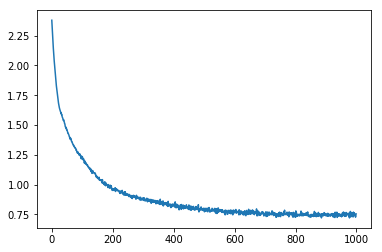

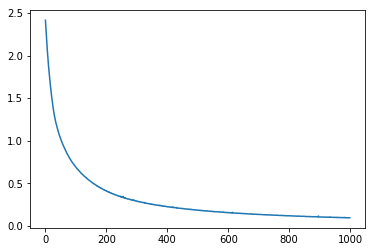

Model Accuracy: 0.7878787878787878


In [14]:
layer = 4
params = [66, 253, 110, 244]
dropout = 0
l_2 = 0.0067
lr=0.000021
epochs = 1000
batch_size = 2
num_of_folds = 5
j = 0

# Splitting the data for k-fold cross validation
x_trains, y_trains, x_tests, y_tests = split_data(x_train, y_2, num_of_folds=num_of_folds)

# defining a model
model = model_define_classifier(params = params, layer_n = layer, input_size = x_trains[j].shape[1], dropout=dropout, l_2=l_2)
model.summary()

# choose your scaler
scale = StandardScaler()
x_train_ = scale.fit_transform(x_trains[j])

# This is the change
x_test_ = scale.transform(x_tests[j])

# evaluating a model
print('Training initiated ..')

optimizer = keras.optimizers.Adam(lr=lr)

score, history = evaluate_model_classifier(model, epochs=epochs, batch_size=batch_size, x_train = x_train_, y_train = y_trains[0], x_test = x_test_, y_test = y_tests[0], verbose = 0, optimizer=optimizer)
plt.plot(history.history['val_loss'])
plt.show()
plt.plot(history.history['loss'])
plt.show()

print('Model Accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 66)                32934     
_________________________________________________________________
dropout_1 (Dropout)          (None, 66)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 253)               16951     
_________________________________________________________________
dropout_2 (Dropout)          (None, 253)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 110)               27940     
_________________________________________________________________
dropout_3 (Dropout)          (None, 110)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 244)               27084     
__________

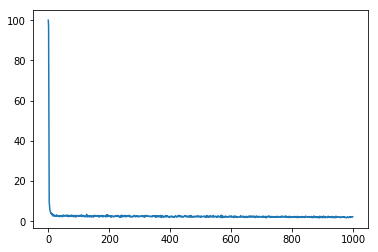

Model Test mean_absolute_percentage_error: 4.978157303550026


In [15]:
layer = 4
params = [11, 1, 80, 95]
dropout = 0.0119
l_2 = 0.0481
lr=0.000262
epochs = 1000
batch_size = 2
num_of_folds = 5
j = 0

# Splitting the data for k-fold cross validation
x_trains, y_trains, x_tests, y_tests = split_data(x_train, y_train, num_of_folds=num_of_folds)

# defining a model
model = model_define(params = params, layer_n = layer, input_size = x_trains[j].shape[1], dropout=dropout, l_2=l_2)
model.summary()

# choose your scaler
scale = StandardScaler()
x_train_ = scale.fit_transform(x_trains[j])

# This is the change
x_test_ = scale.transform(x_tests[j])

# evaluating a model
print('Training initiated ..')

optimizer = keras.optimizers.Adam(lr=lr)

score, history = evaluate_model(model, epochs=epochs, batch_size=batch_size, x_train = x_train_, y_train = y_trains[0], x_test = x_test_, y_test = y_tests[0], verbose = 0, optimizer=optimizer)
plt.plot(history.history['mean_absolute_percentage_error'])
plt.show()

print('Model Test mean_absolute_percentage_error:', score[1])

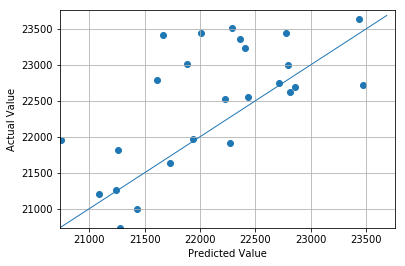

In [16]:
# visualize the prediction
show_comparison_chart(model, x_test_, y_tests[0])

In [17]:
# Ieterative training for hyperparameter tuning for regression

'''
layer = 4
params = [3, 207, 191, 119]
dropout = 0.0119
l_2 = 0.0481
lr=0.000262
epochs = 1000
batch_size = 2
random_state = 0

# score = 1.057-1.501@epoch=1000

'''

layer = None
params = None
dropout = 0.0119
l_2 = 0.0481
lr = 0.000262
epochs = 1000
batch_size = 2
num_of_folds = 5
tries = 1000
neuron_max = 256
batch_size_max = 5
layer_min = 4
layer_max = 4
dropout_max=0.02

# data_df, x_train, y_train, header_x, header_y = data_load(file_to_load, cols_to_remove=cols_to_remove, target_col=target_col, random_state=random_state)
# x_trains, y_trains, x_tests, y_tests = split_data(x_train, y_1, num_of_folds=num_of_folds)
# hp_tuning(tries = tries, lr = lr, x_trains = x_trains, y_trains = y_trains, x_tests = x_tests, y_tests = y_tests, layer = layer, params=params, epochs=epochs, batch_size=batch_size, dropout=dropout, l_2 = l_2, neuron_max=neuron_max, batch_size_max=batch_size_max, layer_min = layer_min, layer_max=layer_max, dropout_max=dropout_max)

In [ ]:
# Ieterative training for hyperparameter tuning for binary classification

'''
layer = 4
params = [3, 207, 191, 119]
dropout = 0.0119
l_2 = 0.0481
lr=0.000262
epochs = 1000
batch_size = 2
random_state = 0

# score = 1.057-1.501@epoch=1000

'''

layer = 4
params = [66, 253, 110, 244]
dropout = True
l_2 = None
lr = None
epochs = 200
batch_size = 2
num_of_folds = 5
tries = 1000
neuron_max = 256
batch_size_max = 5
layer_min = 2
layer_max = 4
dropout_max=0.02

data_df, x_train, y_train, header_x, header_y = data_load(file_to_load, cols_to_remove=cols_to_remove, target_col=target_col, random_state=random_state)
x_train, y_1, y_2 = get_new_x_ys(x_train, idx_of_stress=12)
x_trains, y_trains, x_tests, y_tests = split_data(x_train, y_2, num_of_folds=num_of_folds)

hp_tuning_classification(tries = tries, lr = lr, x_trains = x_trains, y_trains = y_trains, x_tests = x_tests, y_tests = y_tests, layer = layer, params=params, epochs=epochs, batch_size=batch_size, dropout=dropout, l_2 = l_2, neuron_max=neuron_max, batch_size_max=batch_size_max, layer_min = layer_min, layer_max=layer_max, dropout_max=dropout_max)

 -- STARTED, don't panic and wait --
Iteration 0 (fold:1):	[66, 253, 110, 244]	200	0.0006782944732439745	2	 0.02007	   0.758	  94.209	lr=0.000155
Iteration 0 (fold:2):	[66, 253, 110, 244]	200	0.0006782944732439745	2	 0.02007	   0.818	 100.384	lr=0.000155
Iteration 0 (fold:3):	[66, 253, 110, 244]	200	0.0006782944732439745	2	 0.02007	   0.939	 104.029	lr=0.000155
Iteration 0 (fold:4):	[66, 253, 110, 244]	200	0.0006782944732439745	2	 0.02007	   0.853	  99.020	lr=0.000155
average score =  0.8420231729055259
best score =    0.842 [layer=4, params=[[66, 253, 110, 244]], epochs=200, dropout=  0.0007, l_2=  0.0201, batch_size=2, lr=0.000155]
Iteration 1 (fold:1):	[66, 253, 110, 244]	200	0.017950287698503764	2	 0.00198	   0.788	  95.508	lr=0.000252
Iteration 1 (fold:2):	[66, 253, 110, 244]	200	0.017950287698503764	2	 0.00198	   0.848	  97.479	lr=0.000252
Iteration 1 (fold:3):	[66, 253, 110, 244]	200	0.017950287698503764	2	 0.00198	   0.939	  91.584	lr=0.000252
Iteration 1 (fold:4):	[66, 253, 11

In [ ]:
# (y_1) best score =    0.820 [layer=4, params=[[66, 253, 110, 244]], epochs=200, dropout=  0.0139, l_2=  0.0206, batch_size=2, lr=0.000121]
# (y_2) best score =    0.850 [layer=4, params=[[66, 253, 110, 244]], epochs=200, dropout=  0.0180, l_2=  0.0020, batch_size=2, lr=0.000252]
# (y_2) best score =    0.857 [layer=4, params=[[66, 253, 110, 244]], epochs=200, dropout=  0.0180, l_2=  0.0034, batch_size=2, lr=0.000735]
